# Intro to image classification with PyTorch

**Make sure you look at [`Image classification`](Image_classification.ipynb) before coming here.**

We'll use `Pytorch` on its own in this notebook. See the accompanying notebook, [`Image classification with skorch`](Image_classification_with_skorch.ipynb) to see some helper libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

## The fossil dataset

Let's generate a workflow to classify images using a CNN.
We'll make use of a collection of functions in `utils.py` to help process the images found in the `data/fossils` folder.

In [2]:
import numpy as np

ds = np.DataSource('../data/')

X = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_X.npy', mode='rb'))
y = np.load(ds.open('https://geocomp.s3.amazonaws.com/data/fossils_y.npy', mode='rb'))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [4]:
X_train.shape

(498, 1024)

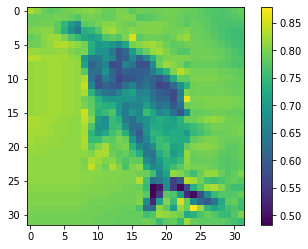

In [5]:
plt.imshow(X_train[1].reshape(32,32))
plt.colorbar()

## `sklearn.neural_network`

We'll first train a fully connected network. This requires the images to be 1D vectors, like the ones we have, but this means we'll lose some of the 2D spatial properties... Until we use a convolutional neural network!

See the notebook [Image classification](Image_classification.ipynb).

In [6]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report

clf = MLPClassifier(hidden_layer_sizes=[100, 24], max_iter=1500)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

   ammonites       0.56      0.89      0.68        28
        fish       0.66      0.56      0.60        34
  trilobites       0.57      0.31      0.40        26

    accuracy                           0.59        88
   macro avg       0.59      0.59      0.56        88
weighted avg       0.60      0.59      0.57        88



We'll start by replicating this in `pytorch`.

## The `pytorch` approach

We'll need to encode the target variable so that the classes are represented by integers. We can use scikit-learn's `LabelEncoder` for that:

In [7]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(np.append(y_train, y_val))

y_train = encoder.transform(y_train)
y_val = encoder.transform(y_val)

In [8]:
y_val

array([2, 1, 2, 1, 1, 0, 1, 1, 0, 0, 0, 0, 2, 1, 2, 0, 1, 2, 2, 1, 1, 1,
       0, 1, 1, 0, 0, 2, 1, 0, 2, 1, 2, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 0,
       2, 2, 0, 2, 1, 1, 0, 1, 0, 2, 1, 2, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0,
       2, 2, 2, 0, 2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 2])

Now we can make a `Sequential` model and train it.

In [9]:
import torch
from torch import nn

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

Define the architecture of the network

In [15]:
class FossilNet(torch.nn.Module):
    def __init__(self):
        super(FossilNet, self).__init__()
        self.fc1 = nn.Linear(1024, 100)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(100, 24)
        self.act2 = nn.ReLU()
        self.out = nn.Linear(24, 3)
        # nb Criterion includes softmax.
        
    def forward(self, x):
        z1 = self.fc1(x)
        a1 = self.act1(z1)
        z2 = self.fc2(a1)
        a2 = self.act2(z2)
        z3 = self.out(a2)
        return z3

model = FossilNet().to(device)

In [16]:
model

FossilNet(
  (fc1): Linear(in_features=1024, out_features=100, bias=True)
  (act1): ReLU()
  (fc2): Linear(in_features=100, out_features=24, bias=True)
  (act2): ReLU()
  (out): Linear(in_features=24, out_features=3, bias=True)
)

Now define the loss function, which Torch calls the 'criterion', and the optimizer:

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr=0.003,
                            weight_decay=0.01,  # L2 regularization.
                            momentum=0.9,
                           )

Get the data ready for Torch:

In [18]:
X_train_ = torch.Tensor(X_train).to(device)
y_train_ = torch.Tensor(y_train).type(torch.LongTensor).to(device)
X_val_ = torch.Tensor(X_val).to(device)
y_val_ = torch.Tensor(y_val).type(torch.LongTensor).to(device)

Now we can write the training loop:

In [19]:
epochs = 1400
vals, trains = [], []
idx = np.arange(0, y_train.size)

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_train_ = X_train_[idx]
    y_train_ = y_train_[idx]
    
    # Train.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_)  # No batches.
    loss = criterion(y_pred, y_train_)  
    loss.backward()
    optimizer.step()
    
    # Capture training loss.
    print(f"Epoch {epoch}/{epochs}: train loss: {loss.item():.3f}")
    trains.append(loss.item())

    # Capture validation loss.
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_)
        loss = criterion(y_pred, y_val_)    
        vals.append(loss.item())

Epoch 0/1400: train loss: 1.098
Epoch 1/1400: train loss: 1.098
Epoch 2/1400: train loss: 1.097
Epoch 3/1400: train loss: 1.097
Epoch 4/1400: train loss: 1.096
Epoch 5/1400: train loss: 1.096
Epoch 6/1400: train loss: 1.095
Epoch 7/1400: train loss: 1.095
Epoch 8/1400: train loss: 1.094
Epoch 9/1400: train loss: 1.094
Epoch 10/1400: train loss: 1.093
Epoch 11/1400: train loss: 1.093
Epoch 12/1400: train loss: 1.093
Epoch 13/1400: train loss: 1.092
Epoch 14/1400: train loss: 1.092
Epoch 15/1400: train loss: 1.092
Epoch 16/1400: train loss: 1.091
Epoch 17/1400: train loss: 1.091
Epoch 18/1400: train loss: 1.090
Epoch 19/1400: train loss: 1.090
Epoch 20/1400: train loss: 1.089
Epoch 21/1400: train loss: 1.089
Epoch 22/1400: train loss: 1.088
Epoch 23/1400: train loss: 1.088
Epoch 24/1400: train loss: 1.087
Epoch 25/1400: train loss: 1.087
Epoch 26/1400: train loss: 1.086
Epoch 27/1400: train loss: 1.086
Epoch 28/1400: train loss: 1.086
Epoch 29/1400: train loss: 1.085
Epoch 30/1400: train

Epoch 257/1400: train loss: 0.926
Epoch 258/1400: train loss: 0.925
Epoch 259/1400: train loss: 0.924
Epoch 260/1400: train loss: 0.923
Epoch 261/1400: train loss: 0.922
Epoch 262/1400: train loss: 0.922
Epoch 263/1400: train loss: 0.921
Epoch 264/1400: train loss: 0.920
Epoch 265/1400: train loss: 0.919
Epoch 266/1400: train loss: 0.918
Epoch 267/1400: train loss: 0.917
Epoch 268/1400: train loss: 0.917
Epoch 269/1400: train loss: 0.916
Epoch 270/1400: train loss: 0.915
Epoch 271/1400: train loss: 0.914
Epoch 272/1400: train loss: 0.913
Epoch 273/1400: train loss: 0.912
Epoch 274/1400: train loss: 0.912
Epoch 275/1400: train loss: 0.911
Epoch 276/1400: train loss: 0.910
Epoch 277/1400: train loss: 0.909
Epoch 278/1400: train loss: 0.908
Epoch 279/1400: train loss: 0.908
Epoch 280/1400: train loss: 0.907
Epoch 281/1400: train loss: 0.906
Epoch 282/1400: train loss: 0.905
Epoch 283/1400: train loss: 0.904
Epoch 284/1400: train loss: 0.904
Epoch 285/1400: train loss: 0.903
Epoch 286/1400

Epoch 521/1400: train loss: 0.787
Epoch 522/1400: train loss: 0.787
Epoch 523/1400: train loss: 0.787
Epoch 524/1400: train loss: 0.786
Epoch 525/1400: train loss: 0.786
Epoch 526/1400: train loss: 0.786
Epoch 527/1400: train loss: 0.785
Epoch 528/1400: train loss: 0.785
Epoch 529/1400: train loss: 0.785
Epoch 530/1400: train loss: 0.784
Epoch 531/1400: train loss: 0.784
Epoch 532/1400: train loss: 0.784
Epoch 533/1400: train loss: 0.783
Epoch 534/1400: train loss: 0.783
Epoch 535/1400: train loss: 0.783
Epoch 536/1400: train loss: 0.782
Epoch 537/1400: train loss: 0.782
Epoch 538/1400: train loss: 0.782
Epoch 539/1400: train loss: 0.781
Epoch 540/1400: train loss: 0.781
Epoch 541/1400: train loss: 0.781
Epoch 542/1400: train loss: 0.780
Epoch 543/1400: train loss: 0.780
Epoch 544/1400: train loss: 0.780
Epoch 545/1400: train loss: 0.779
Epoch 546/1400: train loss: 0.779
Epoch 547/1400: train loss: 0.779
Epoch 548/1400: train loss: 0.778
Epoch 549/1400: train loss: 0.778
Epoch 550/1400

Epoch 780/1400: train loss: 0.688
Epoch 781/1400: train loss: 0.688
Epoch 782/1400: train loss: 0.688
Epoch 783/1400: train loss: 0.687
Epoch 784/1400: train loss: 0.687
Epoch 785/1400: train loss: 0.686
Epoch 786/1400: train loss: 0.686
Epoch 787/1400: train loss: 0.685
Epoch 788/1400: train loss: 0.685
Epoch 789/1400: train loss: 0.684
Epoch 790/1400: train loss: 0.684
Epoch 791/1400: train loss: 0.683
Epoch 792/1400: train loss: 0.683
Epoch 793/1400: train loss: 0.682
Epoch 794/1400: train loss: 0.682
Epoch 795/1400: train loss: 0.681
Epoch 796/1400: train loss: 0.681
Epoch 797/1400: train loss: 0.680
Epoch 798/1400: train loss: 0.680
Epoch 799/1400: train loss: 0.679
Epoch 800/1400: train loss: 0.679
Epoch 801/1400: train loss: 0.678
Epoch 802/1400: train loss: 0.678
Epoch 803/1400: train loss: 0.677
Epoch 804/1400: train loss: 0.677
Epoch 805/1400: train loss: 0.677
Epoch 806/1400: train loss: 0.676
Epoch 807/1400: train loss: 0.676
Epoch 808/1400: train loss: 0.675
Epoch 809/1400

Epoch 1037/1400: train loss: 0.543
Epoch 1038/1400: train loss: 0.543
Epoch 1039/1400: train loss: 0.542
Epoch 1040/1400: train loss: 0.541
Epoch 1041/1400: train loss: 0.541
Epoch 1042/1400: train loss: 0.540
Epoch 1043/1400: train loss: 0.539
Epoch 1044/1400: train loss: 0.539
Epoch 1045/1400: train loss: 0.538
Epoch 1046/1400: train loss: 0.537
Epoch 1047/1400: train loss: 0.537
Epoch 1048/1400: train loss: 0.536
Epoch 1049/1400: train loss: 0.535
Epoch 1050/1400: train loss: 0.535
Epoch 1051/1400: train loss: 0.534
Epoch 1052/1400: train loss: 0.533
Epoch 1053/1400: train loss: 0.533
Epoch 1054/1400: train loss: 0.532
Epoch 1055/1400: train loss: 0.531
Epoch 1056/1400: train loss: 0.531
Epoch 1057/1400: train loss: 0.530
Epoch 1058/1400: train loss: 0.529
Epoch 1059/1400: train loss: 0.529
Epoch 1060/1400: train loss: 0.528
Epoch 1061/1400: train loss: 0.527
Epoch 1062/1400: train loss: 0.526
Epoch 1063/1400: train loss: 0.526
Epoch 1064/1400: train loss: 0.525
Epoch 1065/1400: tra

Epoch 1298/1400: train loss: 0.376
Epoch 1299/1400: train loss: 0.375
Epoch 1300/1400: train loss: 0.375
Epoch 1301/1400: train loss: 0.374
Epoch 1302/1400: train loss: 0.374
Epoch 1303/1400: train loss: 0.373
Epoch 1304/1400: train loss: 0.373
Epoch 1305/1400: train loss: 0.372
Epoch 1306/1400: train loss: 0.371
Epoch 1307/1400: train loss: 0.371
Epoch 1308/1400: train loss: 0.370
Epoch 1309/1400: train loss: 0.370
Epoch 1310/1400: train loss: 0.369
Epoch 1311/1400: train loss: 0.368
Epoch 1312/1400: train loss: 0.368
Epoch 1313/1400: train loss: 0.367
Epoch 1314/1400: train loss: 0.367
Epoch 1315/1400: train loss: 0.366
Epoch 1316/1400: train loss: 0.366
Epoch 1317/1400: train loss: 0.365
Epoch 1318/1400: train loss: 0.364
Epoch 1319/1400: train loss: 0.364
Epoch 1320/1400: train loss: 0.363
Epoch 1321/1400: train loss: 0.363
Epoch 1322/1400: train loss: 0.362
Epoch 1323/1400: train loss: 0.362
Epoch 1324/1400: train loss: 0.361
Epoch 1325/1400: train loss: 0.360
Epoch 1326/1400: tra

And inspect the history:

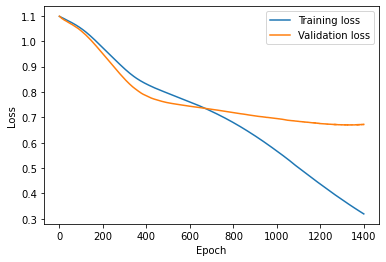

In [20]:
plt.plot(trains, label='Training loss')
plt.plot(vals, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

[Validation loss lower than training loss?](https://twitter.com/aureliengeron/status/1110839223878184960)

This can happen for a few reasons:

- The training loss is measured during the epoch, while validation loss is measured after it. So the model used in validation is a bit better.
- The training loss includes the regularization penalty, whereas the validation loss does not.
- The validation data might be more predictable than the training data.

## Evaluation

In [22]:
y_out = model(X_val_).cpu().detach().numpy()

But these are not probabilities:

In [23]:
np.sum(y_out, axis=-1)

array([ 0.08042264, -0.01406562, -0.01738346, -0.03078741,  0.03440422,
       -0.08054346,  0.01178995,  0.01333195,  0.16341591,  0.07980672,
        0.04951859,  0.02989221,  0.0528605 , -0.01951301,  0.09098649,
        0.06219938,  0.01644832, -0.01583481, -0.01480186,  0.04554048,
       -0.00049162, -0.02301198,  0.01714516, -0.00645179,  0.029349  ,
       -0.00239652,  0.11493516,  0.03118819,  0.03497964,  0.23315859,
       -0.02229384,  0.00898355, -0.02168483, -0.04034694, -0.0384475 ,
       -0.06545508, -0.03616998, -0.01656091,  0.08938253, -0.06095117,
        0.03443193,  0.0588553 , -0.04004276,  0.05664188,  0.06825259,
        0.0739319 ,  0.10495007,  0.09122944, -0.08351827, -0.02846184,
        0.24884152, -0.0356259 ,  0.02770662, -0.01858816, -0.08102801,
        0.00610673,  0.0066126 ,  0.13002014,  0.00442386, -0.12178722,
        0.03909248, -0.00827742,  0.0420686 ,  0.19953656,  0.01660299,
        0.00240904, -0.05554712, -0.05027676,  0.05309695, -0.11

In [24]:
from scipy.special import softmax

y_prob = softmax(y_out, axis=-1)

np.sum(y_prob, axis=-1)

array([1.0000001 , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.        , 1.        , 0.99999976, 1.        ,
       1.0000001 , 0.99999994, 1.0000002 , 0.9999999 , 0.9999999 ,
       1.0000001 , 1.        , 1.        , 0.99999994, 0.9999999 ,
       1.        , 1.        , 0.99999994, 1.0000001 , 1.0000001 ,
       1.        , 0.99999994, 1.        , 1.        , 0.99999994,
       1.        , 1.        , 0.99999994, 0.9999999 , 0.9999999 ,
       0.99999994, 0.9999999 , 0.9999999 , 1.        , 1.        ,
       1.        , 1.        , 0.9999999 , 1.0000002 , 0.99999994,
       0.9999999 , 1.        , 1.        , 1.        , 1.        ,
       1.0000001 , 1.        , 1.        , 1.        , 1.        ,
       0.99999994, 0.99999994, 0.9999998 , 1.        , 0.99999994,
       0.9999999 , 1.        , 1.0000001 , 1.        , 1.        ,
       1.        , 1.0000001 , 1.        , 1.        , 1.        ,
       1.        , 0.9999999 , 0.9999998 , 1.        , 0.99999

That's better!

Now we can find the argmax for each record:

In [25]:
y_pred = np.argmax(y_prob, axis=-1)

In [26]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74        28
           1       0.71      0.65      0.68        34
           2       0.52      0.62      0.56        26

    accuracy                           0.66        88
   macro avg       0.67      0.66      0.66        88
weighted avg       0.67      0.66      0.66        88



## Class probability

The network can emit probabilities. Each instance's vector contains the probability of each class. The argmax of this gives the predicted class.

In our poor result, the classes are almost equally likely.

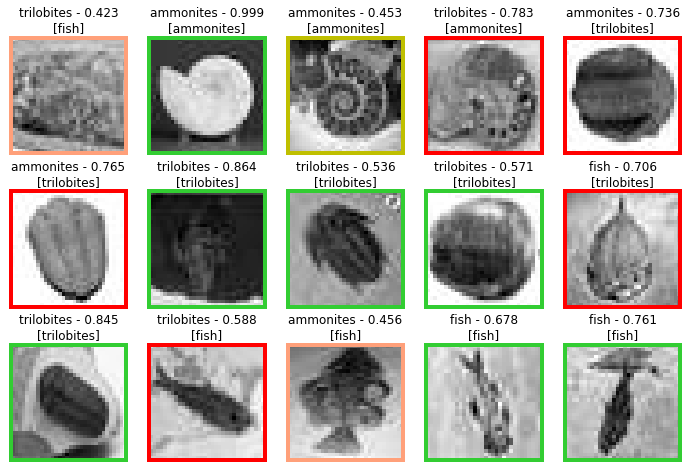

In [27]:
import mlutils

mlutils.visualize(X_val, y_val, y_prob,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_)
plt.show()

## A convolutional neural network

Here's a nice resource on ConvNets: https://cs231n.github.io/convolutional-networks/

What on earth does `BatchNorm` do? Good question: https://blog.paperspace.com/busting-the-myths-about-batch-normalization/

In [167]:
from collections import OrderedDict

class FossilCNN(torch.nn.Module):
    def __init__(self):
        super(FossilCNN, self).__init__()

        # Note that most activations, maxpooling, and dropout are commutative.
        # Pooling reduces dimensions, so doing it first speeds things up.
        # BN is generally not commutative; some place it before activation, some after.
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 24, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2),
            nn.ReLU(),
            nn.BatchNorm2d(24),
        )

        # Another way to define a layer.
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv', nn.Conv2d(24, 8, kernel_size=3, padding=1)),
            ('pool', nn.MaxPool2d(kernel_size=2)),
            ('relu', nn.ReLU()),
            ('bn', nn.BatchNorm2d(8)),])
        )
        
        self.drop_out = nn.Dropout(p=0.25)

        # The last component is an ordinary 'fully connected' neural network.
        # It can also have multiple layers, like any 'vanilla' neural net.
        # The shape comes from 32 x 32 images reduced by convolutions & pooling.
        self.fc = nn.Linear(8 * 8 * 8, 3)
        # No softmax: the criterion includes it.
        
        
    def forward(self, x):
        x = self.layer1(x)

        x = self.layer2(x)
        
        x = torch.flatten(x, start_dim=1)
        x = self.drop_out(x)

        x = self.fc(x)

        return x

model = FossilCNN().to(device)

In [168]:
model

FossilCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (layer2): Sequential(
    (conv): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (relu): ReLU()
    (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (drop_out): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

In [169]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(),
                            lr = 0.003,
                            weight_decay=0.01,  # L2 regularization.
                            momentum=0.9,
                           )

In [170]:
X_train_ = torch.Tensor(X_train.reshape(-1, 1, 32, 32)).to(device)
y_train_ = torch.Tensor(y_train).type(torch.LongTensor).to(device)
X_val_ = torch.Tensor(X_val.reshape(-1, 1, 32, 32)).to(device)
y_val_ = torch.Tensor(y_val).type(torch.LongTensor).to(device)

In [171]:
epochs = 250
vals, trains = [], []
idx = np.arange(0, y_train.size)

for epoch in range(epochs):
    np.random.shuffle(idx)
    X_train_ = X_train_[idx]
    y_train_ = y_train_[idx]
    
    # Train.
    model.train()
    optimizer.zero_grad()
    y_pred = model(X_train_)  # No batches.
    loss = criterion(y_pred, y_train_)  
    loss.backward()
    optimizer.step()
    
    # Capture training loss.
    print(f"Epoch {epoch}/{epochs}: train loss: {loss.item():.3f}")
    trains.append(loss.item())

    # Capture validation loss.
    model.eval()
    with torch.no_grad():
        y_pred = model(X_val_)
        loss = criterion(y_pred, y_val_)    
        vals.append(loss.item())

Epoch 0/250: train loss: 1.327
Epoch 1/250: train loss: 1.271
Epoch 2/250: train loss: 1.173
Epoch 3/250: train loss: 1.111
Epoch 4/250: train loss: 1.021
Epoch 5/250: train loss: 0.952
Epoch 6/250: train loss: 0.937
Epoch 7/250: train loss: 0.888
Epoch 8/250: train loss: 0.863
Epoch 9/250: train loss: 0.835
Epoch 10/250: train loss: 0.803
Epoch 11/250: train loss: 0.792
Epoch 12/250: train loss: 0.754
Epoch 13/250: train loss: 0.758
Epoch 14/250: train loss: 0.746
Epoch 15/250: train loss: 0.733
Epoch 16/250: train loss: 0.714
Epoch 17/250: train loss: 0.711
Epoch 18/250: train loss: 0.697
Epoch 19/250: train loss: 0.686
Epoch 20/250: train loss: 0.695
Epoch 21/250: train loss: 0.680
Epoch 22/250: train loss: 0.667
Epoch 23/250: train loss: 0.670
Epoch 24/250: train loss: 0.650
Epoch 25/250: train loss: 0.650
Epoch 26/250: train loss: 0.637
Epoch 27/250: train loss: 0.635
Epoch 28/250: train loss: 0.605
Epoch 29/250: train loss: 0.623
Epoch 30/250: train loss: 0.599
Epoch 31/250: trai

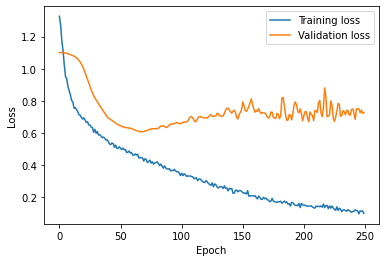

In [172]:
plt.plot(trains, label='Training loss')
plt.plot(vals, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

## Evaluation

Can you evaluate this model? Write a function to handle everything. You will need to:

- Compute the model output to make `y_out` (don't forget to detach the tensor).
- Use the `softmax` function to turn the output into probabilities, `y_pred`.
- Get the argmax of the probabilities to make `y_pred`.
- Return `y_prob` and `y_pred`.
- Print a classification report.

In [173]:
def predict(X, model):
    X = torch.Tensor(X.cpu().reshape(-1, 1, 32, 32)).to(device)
    """Use `model` to predict on `X`."""
    # YOUR CODE HERE
    
    
    return y_prob, y_pred

In [174]:
def predict(X, model):
    X = torch.Tensor(X.cpu().reshape(-1, 1, 32, 32)).to(device)
    y_out = model(X).cpu().detach().numpy()
    y_prob = softmax(y_out, axis=-1)
    y_pred = np.argmax(y_prob, axis=-1)
    return y_prob, y_pred
    
y_prob, y_pred = predict(X_val_, model)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.82      0.79        28
           1       0.74      0.82      0.78        34
           2       0.55      0.42      0.48        26

    accuracy                           0.70        88
   macro avg       0.68      0.69      0.68        88
weighted avg       0.69      0.70      0.69        88



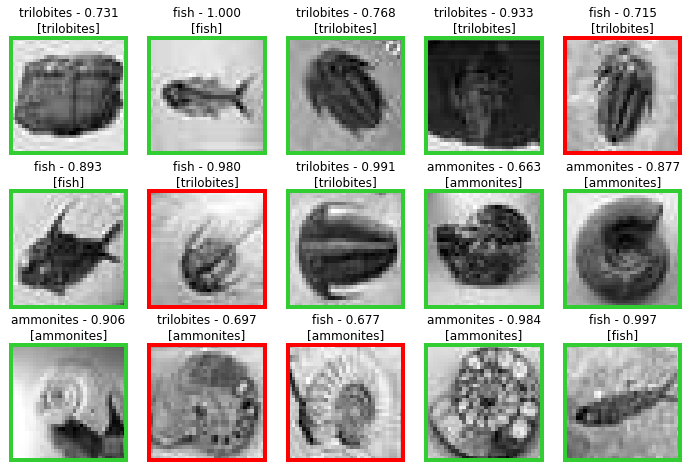

In [175]:
mlutils.visualize(X_val, y_val, y_prob,
                ncols=5, nrows=3,
                shape=(32, 32),
                classes=encoder.classes_
               )

## The kernels

In [176]:
model.layer1

Sequential(
  (0): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

In [177]:
w1 = model.layer1[0].weight.cpu().detach().numpy()
w1.shape

(24, 1, 3, 3)

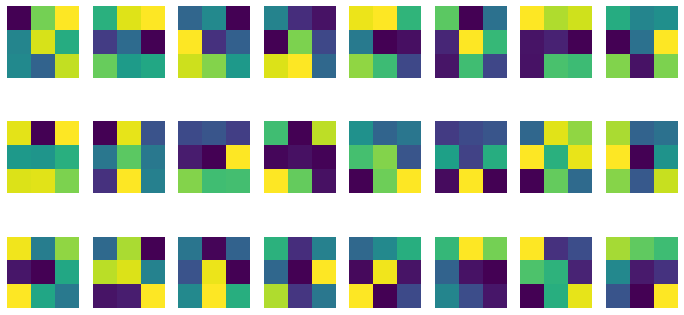

In [178]:
fig, axs = plt.subplots(nrows=3, ncols=8, figsize=(12, 6))
for w, ax in zip(w1, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

We defined Layer 2 in a slightly different way: 

In [180]:
model.layer2

Sequential(
  (conv): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (bn): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)

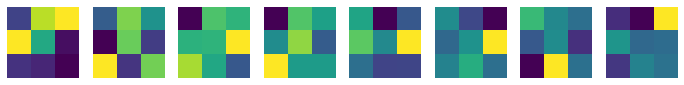

In [182]:
w2 = model.layer2.conv.weight.cpu().detach().numpy()

fig, axs = plt.subplots(nrows=1, ncols=8, figsize=(12, 3))
for w, ax in zip(w2, axs.ravel()):
    ax.imshow(np.sum(w, axis=0))
    ax.axis('off')

## Model persistence and future inference

The easiest way to save a model is with `torch.save`, but `state_dict` is just an `OrderedDict` so you can do anything you want with it.

In [47]:
torch.save(model.state_dict(), './fossilnet.pt')

Later, you or someone else can load it. Note that you need to instantiate the model first; the state dictionary does not contain the architecture.

In [49]:
model = FossilCNN().to(device)
model.load_state_dict(torch.load('./fossilnet.pt'))
model.eval()

FossilCNN(
  (conv1): Conv2d(1, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act1): ReLU()
  (bn1): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(24, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act2): ReLU()
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=512, out_features=3, bias=True)
)

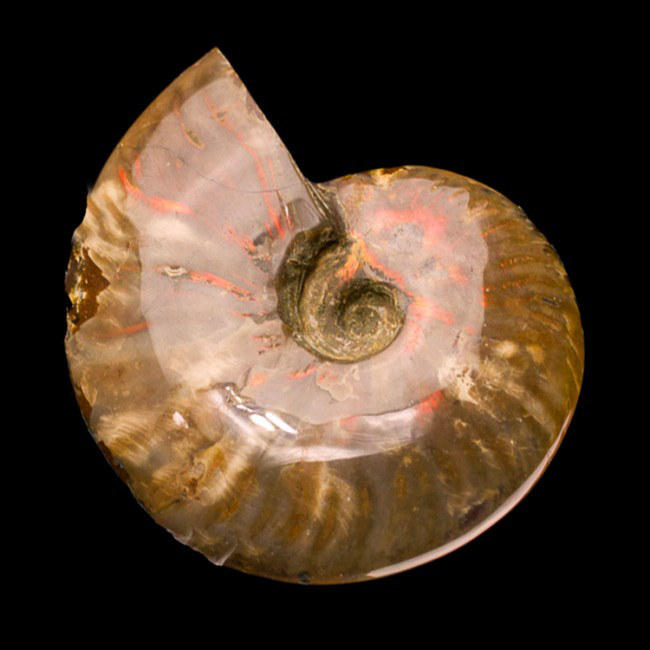

In [50]:
from PIL import Image
import io
import requests

url = "https://www.treasuremountainmining.com/image/cache/data/2017/08-17/Adam30/EB0817AMMOR4-650x650.jpg"
r = requests.get(url)
img = Image.open(io.BytesIO(r.content))
img

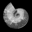

In [51]:
img = img.convert(mode='L')
img.thumbnail(size=(32, 32))
img

In [52]:
ima = np.asarray(img) / 255
ima.shape

(32, 32)

In [53]:
x = torch.Tensor(ima.reshape(-1, 1, 32, 32)).to(device)

y_prob, y_pred = predict(x, model)

print(f"Class {encoder.classes_[y_pred].item().upper():} with p={np.max(y_prob):.3f}")

Class AMMONITES with p=1.000


---

&copy; 2020 Agile Scientific